In [18]:
# import needed libraries for data reader and date time support
from pandas_datareader import data as web
from pandas_datareader._utils import RemoteDataError
from datetime import date, timedelta
import pandas as pd
# import outsourced graphics functionality from graphics.py
# import sys for abort functionality
import sys

while True:
    try:
        # user interaction
        # ask for initial capital and ticker
        start_capital = float(input("Enter your initial capital:\n"))
        date_entry = input('Enter begin of testing range in YYYY-MM-DD format:\n')
        year1, month1, day1 = map(int, date_entry.split('-'))
        start_date = date(year1, month1, day1)
        ticker1 = input("Enter your first ticker available at finance.yahoo.com:\n")
        # ask for testing range and convert to date objects
        # data import: read and parse file containing OHLC data into dataframe using pandas datareader
        # strftime is used to convert from datetime to string in specific format wanted by datareader
        data1 = web.DataReader(str(ticker1),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()),
                                   data_source='yahoo')
        # convert index column to normal column and add standard numbered index column
        #data1.reset_index(inplace=True, drop=False)
        break
    # error handling for wrong ticker input
    except RemoteDataError:
        print("Error. No information for ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker1))
    # error handling for wrong date/starting capital input
    except ValueError:
        print("Error. Enter correct dates and numeric start capital.")

while True:
    try:
        # Use the same structure for the second tickers 
        ticker2 = input("Enter your second ticker available at finance.yahoo.com:\n")
        data2 = web.DataReader(str(ticker2),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()),
                                   data_source='yahoo')
        #data2.reset_index(inplace=True, drop=False)
        break
    except RemoteDataError:
        print("Error. No information for your second ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker2))
    # error handling for wrong date/starting capital input

while True:
    try:
        # Use the same structure for the third ticker
        ticker3 = input("Enter your third ticker available at finance.yahoo.com:\n")
        data3 = web.DataReader(str(ticker3),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()),
                                   data_source='yahoo')
        #data3.reset_index(inplace=True, drop=False)
        break
    except RemoteDataError:
        print("Error. No information for your third ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker3))

while True:
    try:
        # uUse the same strucutre for the fourth ticker
        ticker4 = input("Enter your fourth ticker available at finance.yahoo.com:\n")
        data4 = web.DataReader(str(ticker4),
                                   start=start_date.strftime('%Y-%m-%d'),
                                   end=str(date.today()),
                                   data_source='yahoo')
        #data4.reset_index(inplace=True, drop=False)
        break
    except RemoteDataError:
        print("Error. No information for your fourth ticker '{}'. Only enter tickers available on Yahoo Finance.".format(ticker4))

Enter your initial capital:
 10000

Enter begin of testing range in YYYY-MM-DD format:
 2016-11-11

Enter your first ticker available at finance.yahoo.com:
 AAPL

Enter your second ticker available at finance.yahoo.com:
 MSFT

Enter your third ticker available at finance.yahoo.com:
 AMZN

Enter your fourth ticker available at finance.yahoo.com:
 META

In [19]:
# Dataframe Concatenation
stocks = pd.concat([data1['Close'],data2['Close'],data3['Close'],data4['Close']],axis=1)
stocks.columns = [ticker1,ticker2,ticker3,ticker4]
# for each date we get the closing price of the stocks of interest
stocks


,AAPL,MSFT,AMZN,META
Date,,,,
2016-11-11,27.107500,59.020000,36.950500,119.019997
2016-11-14,26.427500,58.119999,35.953499,115.080002
2016-11-15,26.777500,58.869999,37.161999,117.199997
2016-11-16,27.497499,59.650002,37.324501,116.339996
2016-11-17,27.487499,60.639999,37.820000,117.790001
...,...,...,...,...
2022-11-15,150.039993,241.970001,98.940002,117.080002
2022-11-16,148.789993,241.729996,97.120003,113.230003
2022-11-17,150.720001,241.679993,94.849998,111.449997


In [20]:
# Compute returns: rt = pt-(pt-1)/ (pt-1)
#CHANGE
raw_returns = (stocks-stocks.shift(1))/stocks.shift(1)
raw_returns

,AAPL,MSFT,AMZN,META
Date,,,,
2016-11-11,NaN,NaN,NaN,NaN
2016-11-14,-0.025085,-0.015249,-0.026982,-0.033104
2016-11-15,0.013244,0.012904,0.033613,0.018422
2016-11-16,0.026888,0.013250,0.004373,-0.007338
2016-11-17,-0.000364,0.016597,0.013275,0.012464
...,...,...,...,...
2022-11-15,0.011869,0.001739,0.004569,0.025039
2022-11-16,-0.008331,-0.000992,-0.018395,-0.032883
2022-11-17,0.012971,-0.000207,-0.023373,-0.015720


In [21]:
import numpy as np


# Define the log of returns (because log promotes "fairness")
#CHANGE
logReturns = np.log(1+raw_returns)
logReturns


,AAPL,MSFT,AMZN,META
Date,,,,
2016-11-11,NaN,NaN,NaN,NaN
2016-11-14,-0.025405,-0.015367,-0.027353,-0.033664
2016-11-15,0.013157,0.012822,0.033060,0.018254
2016-11-16,0.026533,0.013163,0.004363,-0.007365
2016-11-17,-0.000364,0.016461,0.013188,0.012386
...,...,...,...,...
2022-11-15,0.011800,0.001737,0.004559,0.024731
2022-11-16,-0.008366,-0.000992,-0.018566,-0.033436
2022-11-17,0.012888,-0.000207,-0.023651,-0.015845


In [22]:
# Determine Sharpe Ratio for every portfolio
# SR(w) = (R(w)-Rf)/σ(w)
# Which proportion should I allocate to each stock? --> I look for best weight factor
# Return vs Volatility Chart (generates almost all possible portfolios)
#We will get the simulated portfolio to get the highest here 

numberPortfolios = 10000

# define Arrays
weight = np.zeros((numberPortfolios,4))
expectedLogReturn = np.zeros(numberPortfolios)
expectedVol = np.zeros(numberPortfolios)
sharpeRatio = np.zeros(numberPortfolios)

meanLogReturn = logReturns.mean()
sigma = logReturns.cov()
for k in range(numberPortfolios):
    # generate random weight vector
    w = np.array(np.random.random(4))
    w = w/np.sum(w)
    weight[k,:] = w
    # expected log return
    expectedLogReturn[k]= np.sum(meanLogReturn*w)
    # expected volatility
    expectedVol[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    # Sharpe ratio
    sharpeRatio[k] = expectedLogReturn[k]/expectedVol[k]


In [23]:
# index of maximal sharpe ratio
maxIndex = sharpeRatio.argmax()
# vector that maximizes sharpe ratio 
weight[maxIndex,:]

array([0.54526898, 0.45092222, 0.0010535 , 0.00275529])

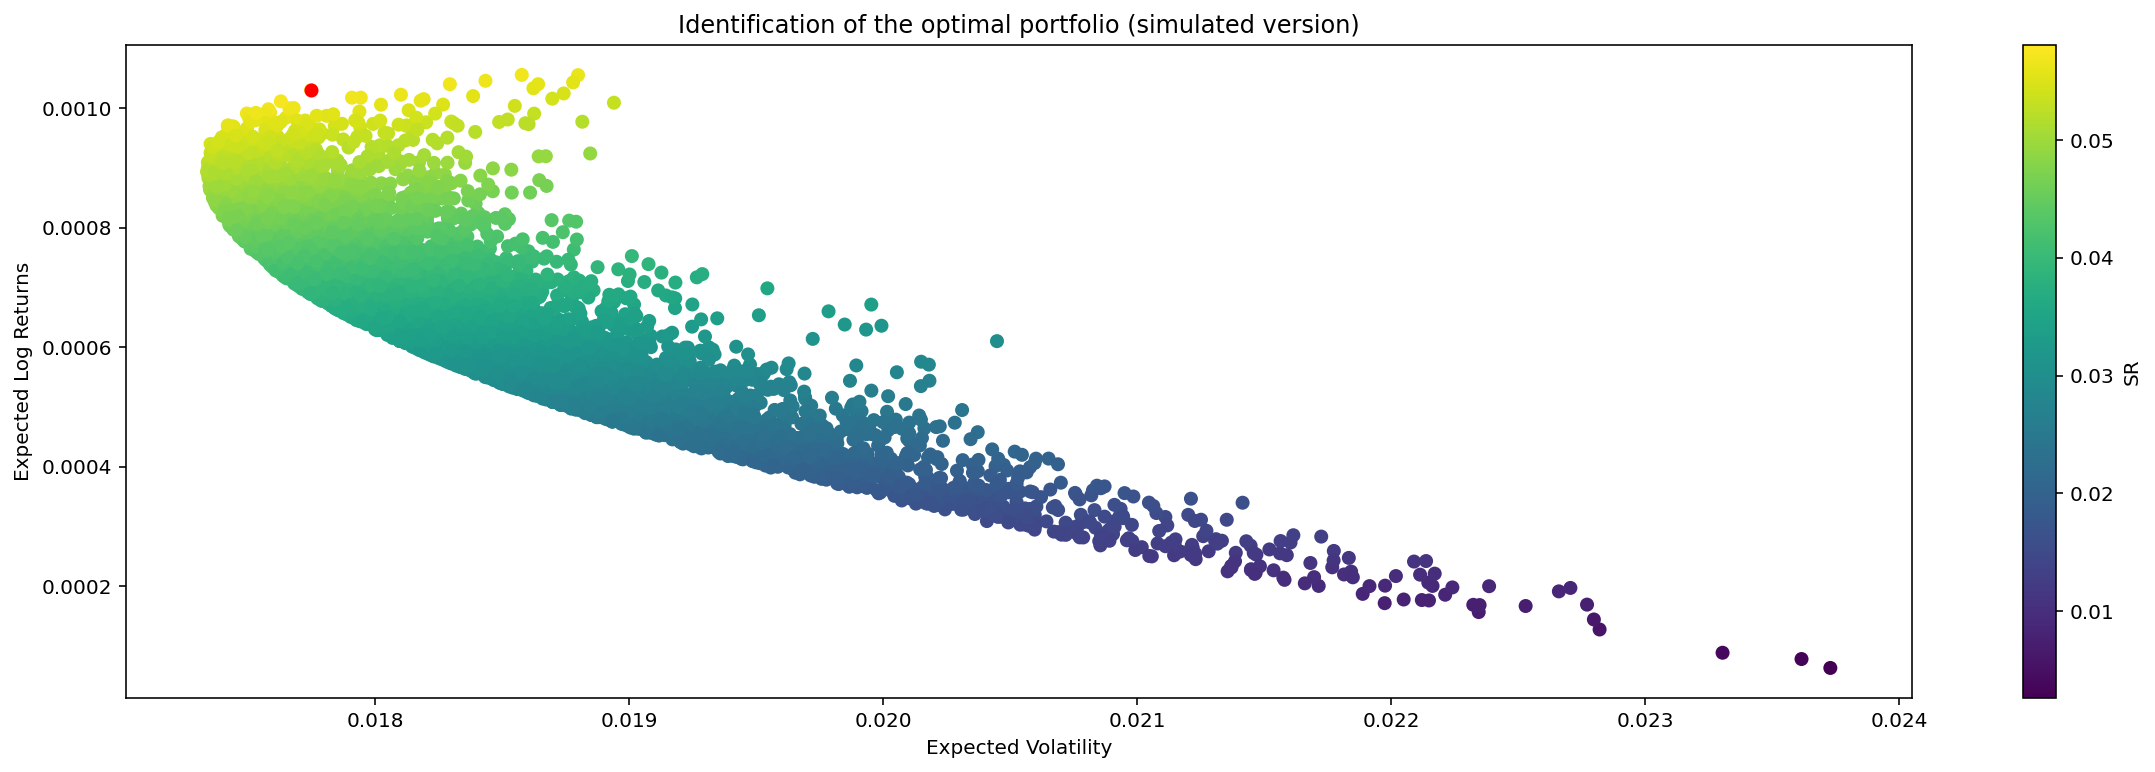

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.scatter(expectedVol,expectedLogReturn,c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVol[maxIndex],expectedLogReturn[maxIndex],c='red')
plt.title("Identification of the optimal portfolio (simulated version)")
plt.show()

In [25]:
# After having identified the simulated version of the portfolio, we will complement 
#the analysis with a the closed-form alternative to find the optimal portfolio. 
# We will use this version to advise user, as results are much more stable
# Efficient Markowitz Frontier

from scipy.optimize import minimize

# a function of weights returning negative SR function
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogReturn*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = R/V
    return -1*SR

# function that takes in weights and returns zero
def checkSumToOne(w):
    return np.sum(w)-1

# w0 is an "initial guess" which is equal weight for all
w0 = [0.25,0.25,0.25,0.25]
# each wi is between 0 and 1
bounds = ((0,1),(0,1),(0,1),(0,1))
# define type and a function
constraints = ({'type':'eq','fun':checkSumToOne})
w_optimal = minimize(negativeSR,w0,method='SLSQP',bounds=bounds,constraints=constraints)
w_optimal

     fun: -0.058444077903951966
     jac: array([-1.96504407e-05,  3.95313837e-05,  1.49599225e-02,  5.40625029e-02])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([6.67956759e-01, 3.32043241e-01, 1.11022302e-16, 0.00000000e+00])

In [26]:
# Obtain the optimal vector that maximizes Sharpe Ratio
opti_w = w_optimal.x
opti_return = sum(opti_w * meanLogReturn)
opti_vol= np.sqrt(np.dot(opti_w.T,np.dot(sigma,opti_w)))

In [27]:
minExpectedLogReturn = min(expectedLogReturn)
maxExpectedLogReturn = max(expectedLogReturn)

In [28]:
# Obtain the Efficient Markowitz Frontier (is on the boundary of the above scatterplot)
# for each return (each horizontal line) we plot we find the best volatility and then plot the frontier
returns = np.linspace(minExpectedLogReturn,maxExpectedLogReturn,100)

v_optimal = []

# function that takes in weights and returns volatility
def minimizeVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V

def getReturn(w):
    w = np.array(w)
    R = np.sum(meanLogReturn*w)
    return R

for R in returns:
    # find best volatility (as we target minimal volatility we need a constraint on the returns)
    constraints = ({'type':'eq','fun':checkSumToOne},
                  {'type':'eq','fun': lambda w: getReturn(w) - R})
    opt = minimize(minimizeVolatility,w0,method='SLSQP',bounds=bounds,constraints=constraints)
    # save optimal volatility
    v_optimal.append(opt['fun'])


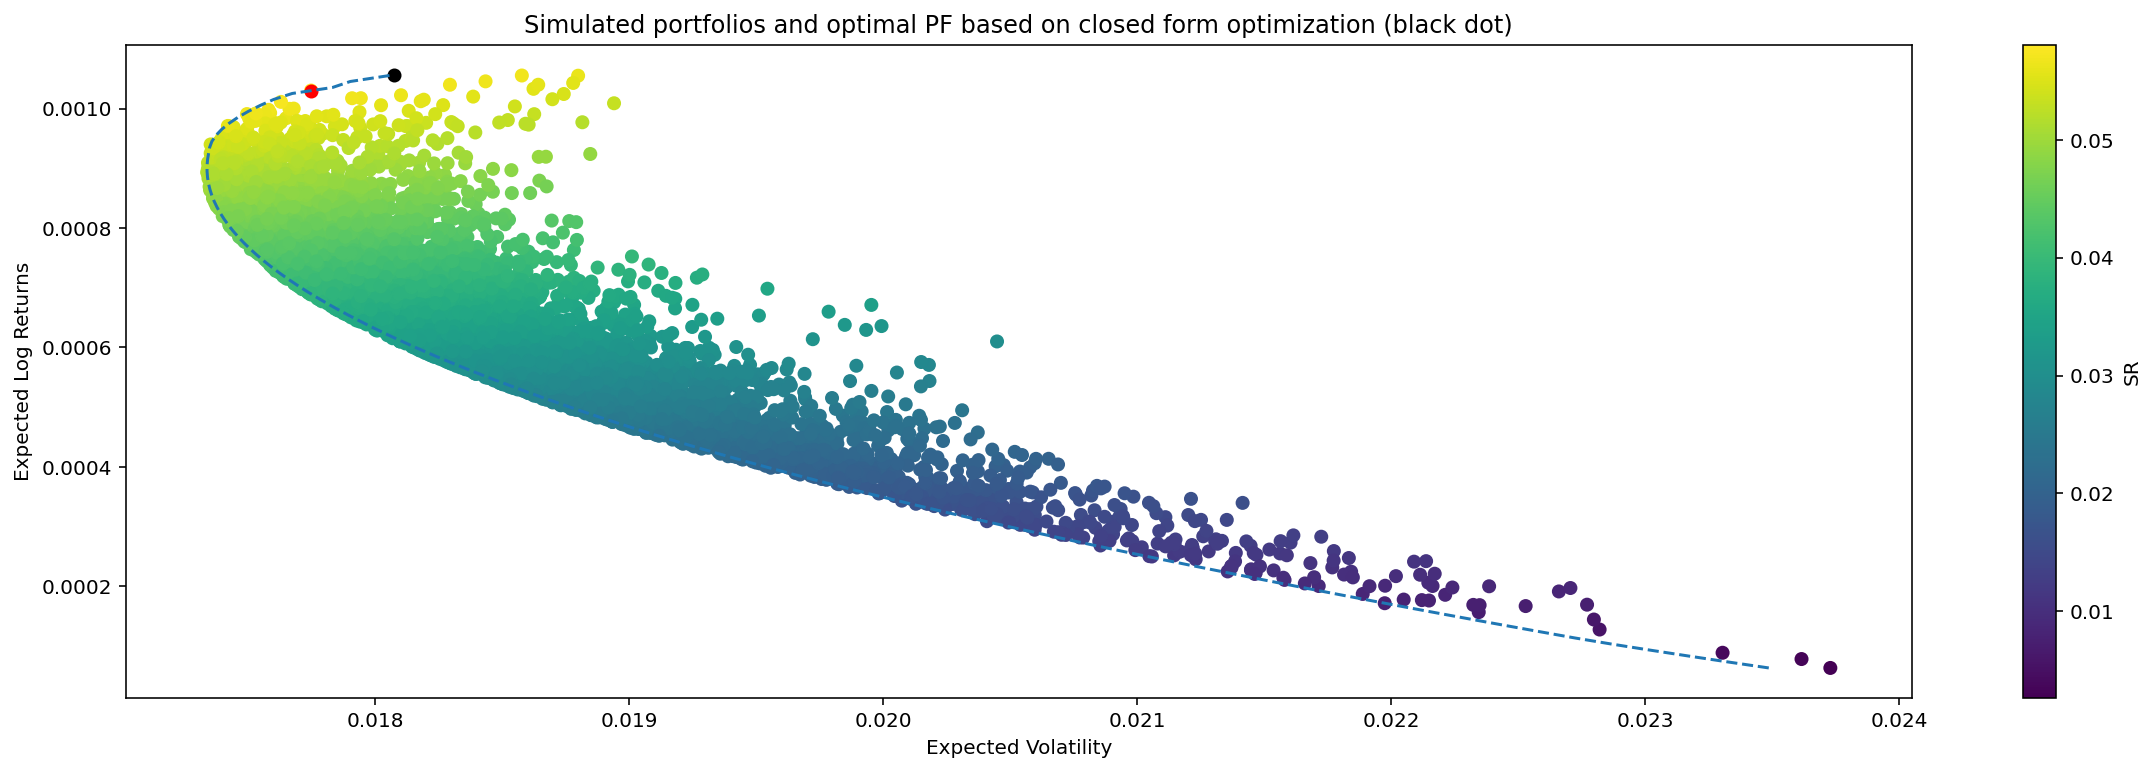

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.scatter(expectedVol,expectedLogReturn,c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVol[maxIndex],expectedLogReturn[maxIndex],c='red')
plt.scatter(opti_vol, opti_return, c="black")
plt.plot(v_optimal,returns,'--')
plt.title("Simulated portfolios and optimal PF based on closed form optimization (black dot)")
plt.show()

In [32]:
print("The optimal weight for {} is {}%, for {} is {}%, for {} is {}% and for {} is {}%.".format(ticker1,round(opti_w[0],2)*100,ticker2,round(opti_w[1],2)*100,ticker3,round(opti_w[2],2)*100,ticker4,round(opti_w[3],2)*100))



print("According to the optimal weights you should invest {}.- in {}, {}.- in {}, {}.- in {} and {}.- isn {}.".format(round(opti_w[0]*start_capital,2),ticker1,round(opti_w[1]*start_capital,2),ticker2,round(opti_w[2]*start_capital,2),ticker3,round(opti_w[3]*start_capital,2),ticker4))




The optimal weight for AAPL is 67.0%, for MSFT is 33.0%, for AMZN is 0.0% and for META is 0.0%.
According to the optimal weights you should invest 6679.57.- in AAPL, 3320.43.- in MSFT, 0.0.- in AMZN and 0.0.- isn META.


Date
2016-11-14    0.978181
2016-11-15    1.013131
2016-11-16    1.022360
2016-11-17    1.005268
2016-11-18    0.999080
                ...   
2022-11-15    1.008506
2022-11-16    0.994106
2022-11-17    1.008596
2022-11-18    1.001894
2022-11-21    0.985591
Length: 1516, dtype: float64


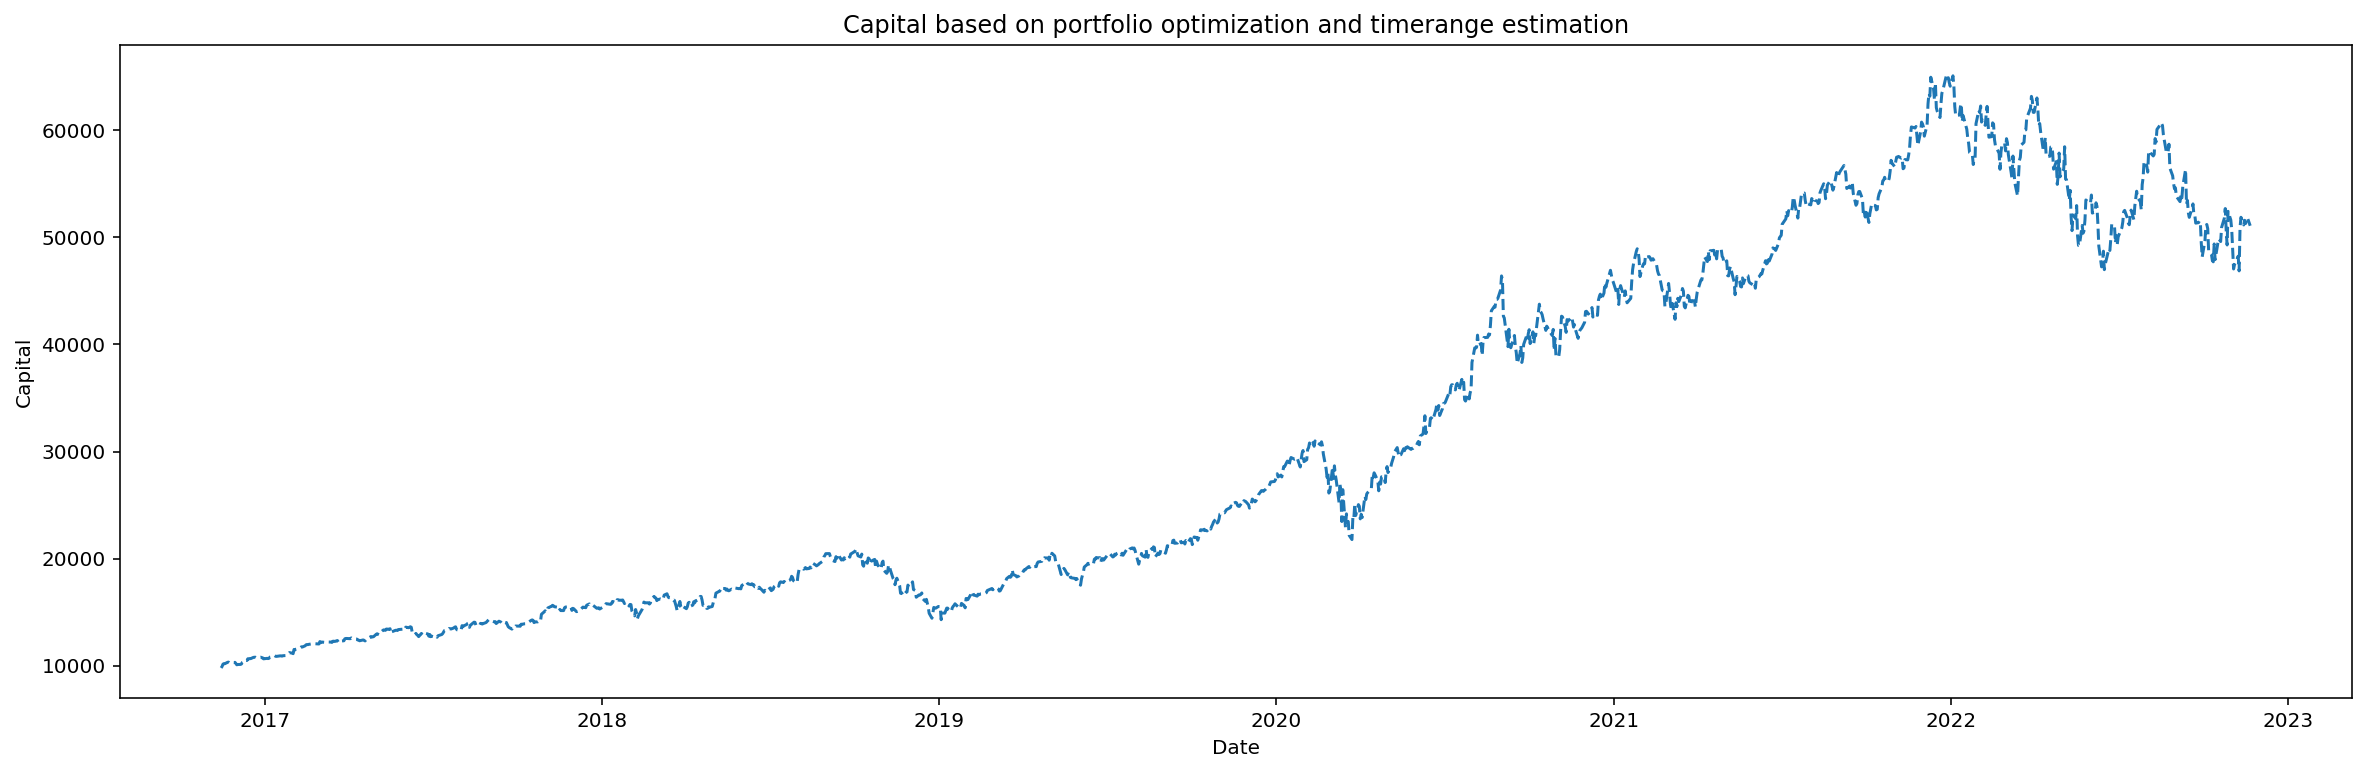

In [31]:
# Based on the weights calculated in the Markowitz Optimization we simulate the portfolio performance throughout the timeframe chosen by the user
portfolio_returns = raw_returns.dot(opti_w.T)
portfolio_returns_factors = portfolio_returns + 1
pf_2 = portfolio_returns_factors.dropna()
print(pf_2)

port_ret_cleaned_1= pf_2.cumprod()

chart = port_ret_cleaned_1 * start_capital

plt.figure(figsize=(20,6))
plt.xlabel("Date")
plt.ylabel("Capital")
plt.plot(chart,'--')
plt.title('Capital based on portfolio optimization and timerange estimation',fontsize=12)

plt.show()